In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import os
import glob
from regression import lin_reg_model, k_fold_cross_validation

pd.set_option('display.max_columns', None)

### Агрегация CSV файлов

In [2]:
DATA_DIR = "/home/denis/Godis/Projects/IS-Tasks/data/"
dfs = [pd.read_csv(file) for file in glob.glob(f"{DATA_DIR}/*.csv")]
original_df = pd.concat(dfs, ignore_index=True)

### Первичная фильтрация данных

In [3]:
df = original_df[[
 'QUARTER',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'ORIGIN_AIRPORT_ID',
 'OP_UNIQUE_CARRIER',
 'DEST_AIRPORT_ID',
 'ORIGIN_STATE_NM',
 'DEST_AIRPORT_ID',
 'DEST_CITY_NAME',
 'DEST_STATE_NM',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'DISTANCE'
]]

# Выбираем только один штат
df = df[df.ORIGIN_STATE_NM == 'Iowa']
df = df.dropna()

# Конвертируем время hhmm в минуты
time = df['CRS_DEP_TIME'].copy()
df['CRS_DEP_TIME'] = time % 100 + 60 * (time // 100)

## Изучение данных

In [4]:
df.head()

,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,OP_UNIQUE_CARRIER,DEST_AIRPORT_ID,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,DISTANCE
0,2,19,7,11423,9E,13487,Iowa,13487,"Minneapolis, MN",Minnesota,414,-4.0,232.0
2,2,19,7,11423,9E,12953,Iowa,12953,"New York, NY",New York,805,46.0,1031.0
4,2,12,7,11423,9E,13487,Iowa,13487,"Minneapolis, MN",Minnesota,489,-6.0,232.0
32,2,27,1,11423,9E,13487,Iowa,13487,"Minneapolis, MN",Minnesota,656,-7.0,232.0
34,2,4,6,11423,9E,11433,Iowa,11433,"Detroit, MI",Michigan,510,-10.0,534.0


(array([2.8346e+04, 3.6000e+02, 6.6000e+01, 1.1000e+01, 1.9000e+01,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ -29. ,  180.3,  389.6,  598.9,  808.2, 1017.5, 1226.8, 1436.1,
        1645.4, 1854.7, 2064. ]),
 <a list of 10 Patch objects>)

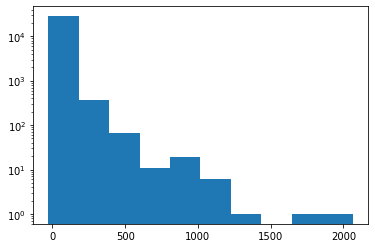

In [5]:
# как распределена целевая переменная
plt.hist(df["DEP_DELAY"], log=True)

In [6]:
X = df.drop(columns=["DEP_DELAY", "ORIGIN_STATE_NM", "DEST_CITY_NAME"])
y = df["DEP_DELAY"]

### Числовые признаки

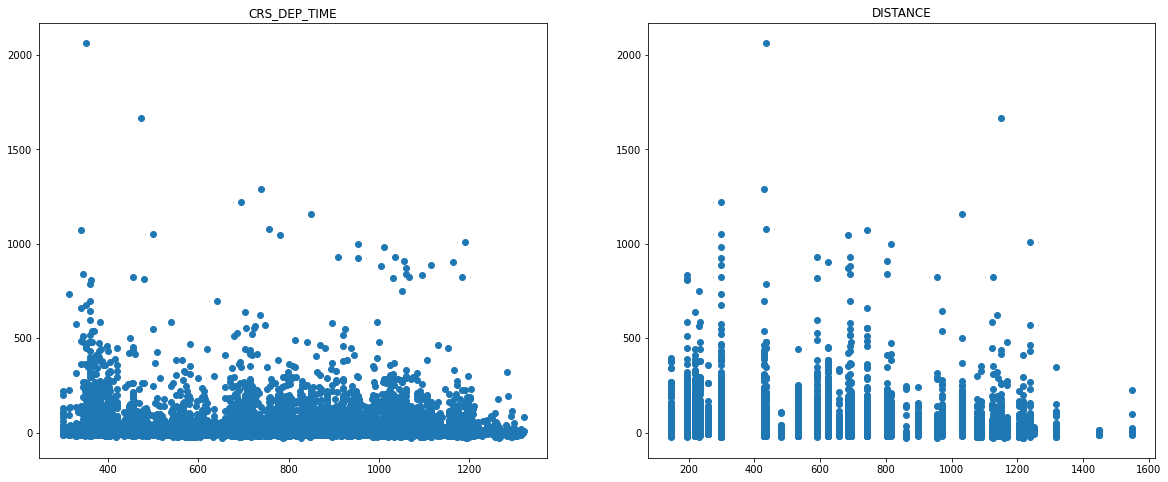

In [7]:
numerical = ["CRS_DEP_TIME", "DISTANCE"]
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for i in range(2):
    col_name = numerical[i]
    x_i = X[col_name]
    axs[i].scatter(x_i, y)
    axs[i].set_title(col_name)

### Категориальные признаки

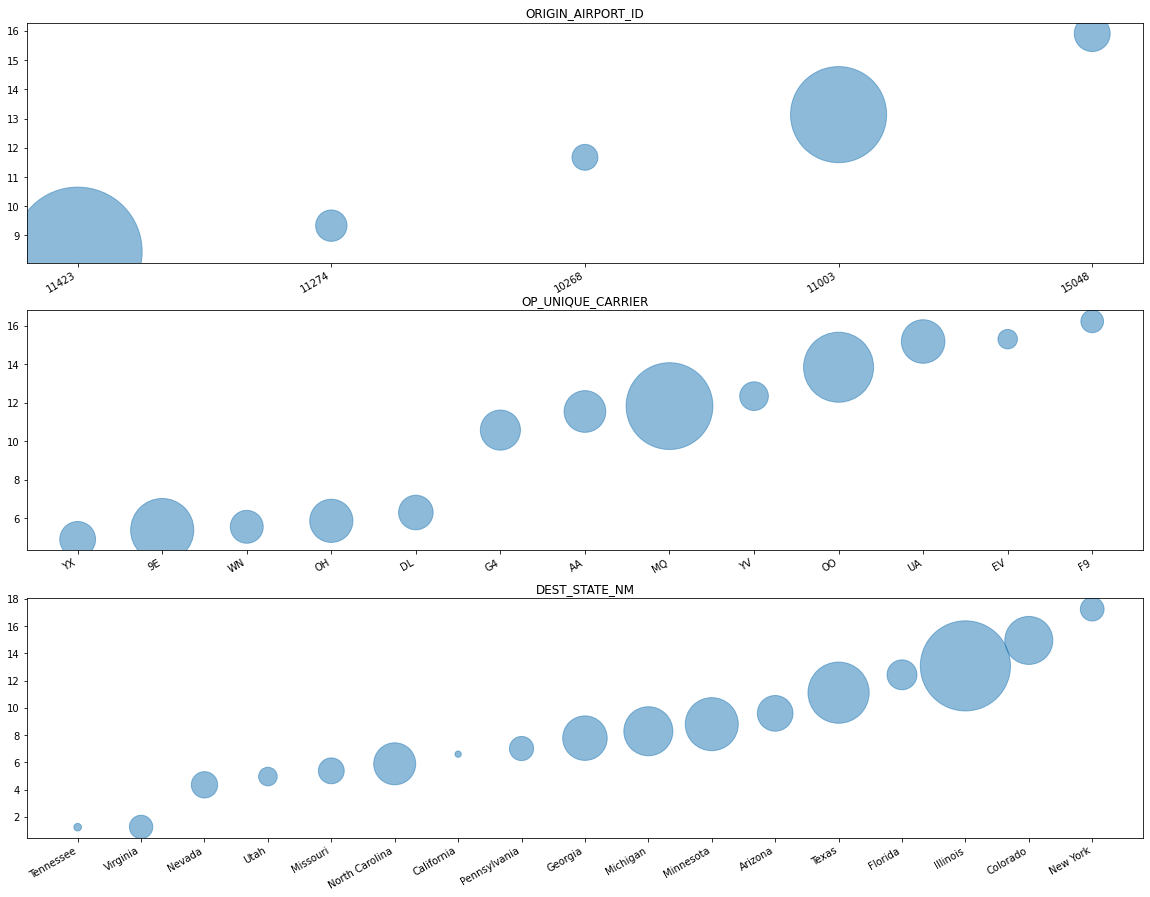

In [8]:
categorial = ["ORIGIN_AIRPORT_ID", "OP_UNIQUE_CARRIER", "DEST_STATE_NM"]
fig, axs = plt.subplots(3, figsize=(20, 15))
for i in range(3):
    col_name = categorial[i]
    df_copy = df.copy()
    df_copy["COUNT"] = 1
    agg = df_copy.groupby(col_name).agg({
        "DEP_DELAY": "mean",
        "COUNT": "count"
    }).sort_values(by=["DEP_DELAY"])
    data = pd.DataFrame({
        "X": agg.index.astype("str"),
        "Y": agg["DEP_DELAY"],
        "bubble_size": agg["COUNT"]
    })
    axs[i].scatter('X', 'Y', s='bubble_size', data=data, alpha=0.5)
    axs[i].set_title(col_name)
    plt.setp(axs[i].get_xticklabels(), rotation=30, horizontalalignment='right')

### Признаки, связанные со временем

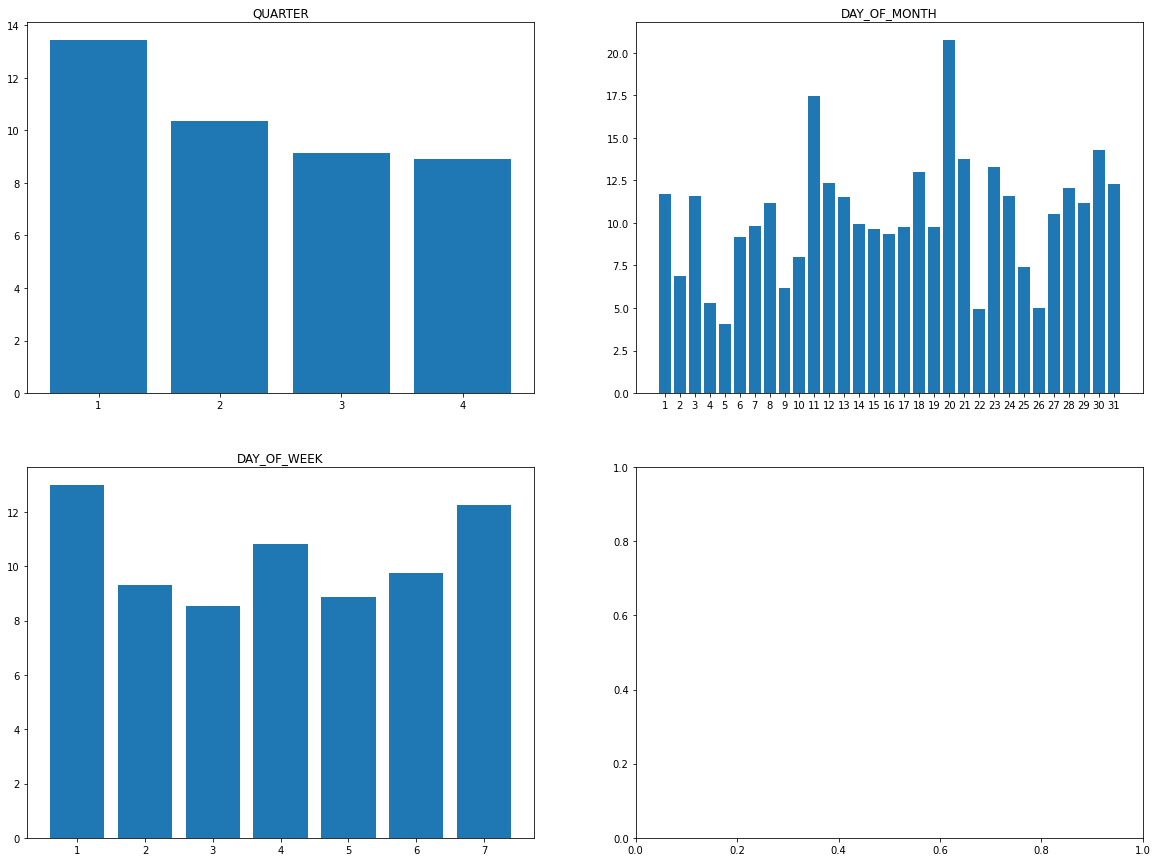

In [9]:
periodical = ["QUARTER", "DAY_OF_MONTH", "DAY_OF_WEEK"]
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(3):
    ax = axs[i//2, i%2]
    col_name = periodical[i]
    agg = df_copy.groupby(col_name).agg("mean").sort_values(by=[col_name])
    ax.bar(agg.index.astype("str"), agg["DEP_DELAY"])
    ax.set_title(col_name)

## Подготовка данных

In [10]:
prep_df = df.copy()

prep_df = prep_df[prep_df["DEP_DELAY"] < 1500]

# берем первые 1500 строк и перемешиваем
prep_df = prep_df.sample(frac=1, random_state=1)[:1500]

# выбираем числовые признаки
prep_df = prep_df[[
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'DISTANCE'
]].dropna()

### One Hot Encoding

In [11]:
for_one_hot = ["OP_UNIQUE_CARRIER"]

for col_name in for_one_hot:
    unique_values = df[col_name].unique()
    for val in unique_values:
        mask = df[col_name] == val
        new_col_name = f"{col_name}__{val}"
        prep_df[new_col_name] = 0
        prep_df.loc[mask, new_col_name] = 1
        
prep_df.head()

,CRS_DEP_TIME,DEP_DELAY,DISTANCE,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__DL,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__YV,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__OH,OP_UNIQUE_CARRIER__EV
57209,334,-5.0,897.0,0,0,0,0,0,0,0,0,0,0,1,0,0
23071,360,9.0,692.0,0,0,0,0,0,1,0,0,0,0,0,0,0
16961,363,-4.0,234.0,0,0,0,0,0,0,0,1,0,0,0,0,0
11991,840,-7.0,534.0,1,0,0,0,0,0,0,0,0,0,0,0,0
37939,875,80.0,1149.0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Перемешивание и выборка

In [12]:
X = prep_df.drop(columns=["DEP_DELAY"])
Y = prep_df["DEP_DELAY"]

### Нормализация

In [13]:
X = X / X.aggregate("max")

## Кросс-валидация

In [17]:
model = lin_reg_model()
k_fold_cross_validation(model, X, Y, 15, fit_params={
    "algorithm": "RMSProp"
})

Step 1: MAE = 17.730155781655107, MSE = 2122.7067639165257
Step 2: MAE = 13.789257129262724, MSE = 634.1511633630298
Step 3: MAE = 19.85033826900422, MSE = 1967.0745835293412
Step 4: MAE = 13.569040919949883, MSE = 702.9065932554363
Step 5: MAE = 12.192522128394556, MSE = 327.55936832100446
Step 6: MAE = 20.34963891394174, MSE = 1495.9374752768638
Step 7: MAE = 15.24859024667101, MSE = 1446.4995041513678
Step 8: MAE = 27.209032163386063, MSE = 6411.107185572925
Step 9: MAE = 11.53242325703637, MSE = 404.04027154851906
Step 10: MAE = 19.39334786195452, MSE = 2690.7581887426704
Step 11: MAE = 16.118369382611615, MSE = 1444.1040839314896
Step 12: MAE = 14.28254696074069, MSE = 1046.047380920768
Step 13: MAE = 20.97769267145467, MSE = 3202.9836142912045
Step 14: MAE = 17.30580786148102, MSE = 903.4194917680501
Step 15: MAE = 14.330822875867286, MSE = 534.1854172057069
Average MAE: 16.92530576156076
Average MSE: 1688.8987390529937


In [373]:
class BaselineModel:
    def fit(self, X, Y):
        self.mean = Y.mean()
        
    def predict(self, X):
        return self.mean

In [396]:
model = BaselineModel()
k_fold_cross_validation(model, X, Y, 15)

Step 1: MAE = 21.228899999999996, MSE = 2028.9488250000002
Step 2: MAE = 16.879114285714287, MSE = 659.0480290816326
Step 3: MAE = 21.601228571428575, MSE = 1857.1627270408164
Step 4: MAE = 16.8772, MSE = 744.1396326530613
Step 5: MAE = 15.444799999999995, MSE = 368.9732000000001
Step 6: MAE = 22.50188571428571, MSE = 1457.31631632653
Step 7: MAE = 18.27985714285714, MSE = 1433.1226045918365
Step 8: MAE = 29.282571428571423, MSE = 6306.100693877553
Step 9: MAE = 15.083257142857146, MSE = 442.34732244897964
Step 10: MAE = 22.443599999999996, MSE = 2680.4286999999995
Step 11: MAE = 18.29265714285714, MSE = 1465.2187653061226
Step 12: MAE = 17.346999999999998, MSE = 1020.0470999999999
Step 13: MAE = 23.267742857142856, MSE = 3145.110479591836
Step 14: MAE = 18.773999999999997, MSE = 846.5752249999999
Step 15: MAE = 16.462371428571426, MSE = 519.4100290816326
Average MAE: 19.58441238095238
Average MSE: 1664.9299766666666
